# GNN for Link + Vote Prediction

This notebook trains a **Graph Neural Network (GraphSAGE)** to predict, for a pair *(voter u, candidate t)*:

- **Link existence**: will *u* vote on *t*? (`NoVote` vs `Voted`)
- **Vote polarity** (if voted): `Oppose`, `Neutral`, or `Support`

We output a 4-class prediction, but train hierarchically with two heads: link existence and vote polarity.

Key implementation choices:
- **No leakage**: message passing uses only **training positive edges**.
- **Mini-batch training** with **LinkNeighborLoader**: each batch samples a subgraph around the queried links.
- **Negative sampling**: we create `NoVote` examples by sampling users who did **not** vote for the same candidate.

## Setup

In [ ]:
# Import Packages
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
import random
from datetime import datetime
import locale
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import coalesce, remove_self_loops

## Data loading

Load and parse the wiki-RfA dataset from the .txt.gz file into (SRC, TGT, VOT) tuples.

Invalid samples are filtered out.

In [ ]:
# Impostiamo il locale per assicurarci che i mesi in inglese (April, May, etc.) 
# vengano riconosciuti correttamente indipendentemente dalla lingua del tuo sistema operativo.
# 'C' è il locale di default POSIX (generalmente inglese).
locale.setlocale(locale.LC_TIME, 'C')

def parse_date_to_int(date_str):
    """
    Converte una data stringa in intero YYYYMMDD.
    Gestisce sia il formato esteso (19 April 2013) che abbreviato (15 Jan 2005).
    """
    if not isinstance(date_str, str):
        print(type(date_str))
        return "TYPE_ERROR"
    
    if len(date_str) == 0:
        return "EMPTY"
    
    formats_to_try = [
        "%H:%M, %d %B %Y",  # Es: "23:13, 19 April 2013" (%B = mese completo)
        "%H:%M, %d %b %Y"   # Es: "23:25, 15 Jan 2005"   (%b = mese abbreviato)
    ]
    for fmt in formats_to_try:
        try:
            # Trasform the string in an abject datetime
            dt_obj = datetime.strptime(date_str, fmt)
            # Casting and reformatting
            return int(dt_obj.strftime("%Y%m%d"))
        except ValueError:
            # If it fails, pass to the next format
            continue

    return "ERROR"
    
print("Esempio: da \"23:13, 19 April 2013\" ad", parse_date_to_int("23:13, 19 April 2013"))

Esempio: da "23:13, 19 April 2013" ad 20130419


In [ ]:
print(f"Print first 10 lines of the dataset:")
printed = 0
errors = {"TYPE_ERROR": [], "EMPTY": [], "ERROR": []}

# Load Dataset
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()

        if printed < 10: 
            print(line)
            printed += 1

        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block and "DAT" in block:
                int_date = parse_date_to_int(block["DAT"])
                # verify if date parsing failed
                if int_date in ["TYPE_ERROR", "EMPTY", "ERROR"]:
                    errors[int_date].append((block["SRC"], block["TGT"], block["DAT"])) # store skipped edges for error analysis
                else:
                    samples.append((block["SRC"], block["TGT"], int(block["VOT"]), int_date))
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print("-"*7 + " Dataset Loaded " + "-"*7)
print(f"\nTotal samples: {len(samples)}")
print(f"Example sample: {samples[0]}")  # Print an example sample
# Print error encountered during date parsing
for error_type, error_list in errors.items():
    print(f"{error_type}: {len(error_list)}")
    for edge in error_list[:3]:  # Print first 3 errors of each type
        print(f"  Skipped edge: {edge}")

Print first 10 lines of the dataset:
SRC:Steel1943
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:23:13, 19 April 2013
TXT:'''Support''' as co-nom.

SRC:Cuchullain
TGT:BDD

Total samples: 188904
Example sample: ('Steel1943', 'BDD', 1, 20130419)
Date parsing errors summary:
TYPE_ERROR: 0
EMPTY: 9367
  Skipped edge: ('', 'Jason Quinn', '')
  Skipped edge: ('', 'Jason Quinn', '')
  Skipped edge: ('', 'Legoktm', '')
ERROR: 4
  Skipped edge: ('JonasEncyclopedia', 'Zagalejo', '14:47, 1 Julu 2012')
  Skipped edge: ('HJ Mitchell', 'Alan16', '20:44, 3 Janry 2010')
  Skipped edge: ('Pathoschild', 'Werdna', '31:29, 24 May 2008')


## User encoding

Encode Wikipedia usernames into contiguous integer node IDs.

In [4]:
# Encode users as numerical IDs
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11128
[('MelbourneStar1', np.int64(6214)), ('Lake54', np.int64(5538)), ('B.hotep', np.int64(941)), ('Microtony', np.int64(6306)), ('luvcraft', np.int64(10963)), ('Dreamspy', np.int64(2817)), ('Distributor108', np.int64(2663)), ('Dino', np.int64(2644)), ("Lear's Fool", np.int64(5594)), ('Avruch', np.int64(908))]


In [5]:
def create_pyg_data(num_nodes, edge_index):
    x = torch.arange(num_nodes, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

In [6]:
# Dataset build (edge list + label)
X = []
y = []
dates = []

for src, tgt, vot, dat in samples:
    if src in user_map and tgt in user_map:
        X.append([user_map[src], user_map[tgt]])
        y.append(vot)
        dates.append(dat)
        
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

# labels for positives: {-1,0,1} -> {1,2,3}
y_pos = y + 2
print("Positive edges:", X.size(0))

Positive edges: 188904


### Train - Validation - Test split

This function divide the whole dataset in three parts based on the date. The outputs are ordered by date.

**idea:** maby we should quantize about the month not about the day

In [ ]:
def train_val_test_split_by_date(X, y, dates, val_ratio=0.15, test_ratio=0.15):
    """
    Splits edges into train, validation, and test sets based on date.
    Edges with the earliest dates go to training, then validation, then test.
    """
    # Convert to numpy for easier sorting
    X_np = X.numpy()
    y_np = y.numpy()
    dates_np = np.array(dates)

    # Get sorted indices based on dates
    sorted_indices = np.argsort(dates_np)

    num_edges = len(dates_np)
    num_val = int(num_edges * val_ratio)
    num_test = int(num_edges * test_ratio)
    num_train = num_edges - num_val - num_test

    train_indices = sorted_indices[:num_train]
    val_indices = sorted_indices[num_train:num_train + num_val]
    test_indices = sorted_indices[num_train + num_val:]

    X_train = torch.tensor(X_np[train_indices], dtype=torch.long)
    y_train = torch.tensor(y_np[train_indices], dtype=torch.long)

    X_val = torch.tensor(X_np[val_indices], dtype=torch.long)
    y_val = torch.tensor(y_np[val_indices], dtype=torch.long)

    X_test = torch.tensor(X_np[test_indices], dtype=torch.long)
    y_test = torch.tensor(y_np[test_indices], dtype=torch.long)

    return (X_train, y_train, dates_np[train_indices]), (X_val, y_val, dates_np[val_indices]), (X_test, y_test, dates_np[test_indices])

(X_tr_pos, y_tr_pos, dates_tr), (X_val_pos, y_val_pos, dates_val), (X_test_pos, y_test_pos, dates_test) = train_val_test_split_by_date(X, y_pos, dates)

# Splits summary
print(f"Training set shape: {X_tr_pos.shape} between dates {dates_tr.min()} and {dates_tr.max()}")
print(f"Validation set shape: {X_val_pos.shape} between dates {dates_val.min()} and {dates_val.max()}")
print(f"Test set shape: {X_test_pos.shape} between dates {dates_test.min()} and {dates_test.max()}")

Training set shape: torch.Size([132234, 2]) between dates 20030816 and 20081023
Validation set shape: torch.Size([28335, 2]) between dates 20081023 and 20100413
Test set shape: torch.Size([28335, 2]) between dates 20100413 and 20130605


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # oppure 'mps' su Mac
num_users = len(user_map)

# Message-passing graph MUST contain only TRAIN POSITIVE edges (to avoid leakage)
train_edge_index = X_tr_pos.t().contiguous()  # [2, E_train_pos]

train_edge_index, _ = remove_self_loops(train_edge_index)
self_loops = X_tr_pos.size(0) - train_edge_index.size(1)
if self_loops > 0:
    print(f"ATTENTION: there are {self_loops} self-loops in the training positive edges which have been removed.")

train_edge_index, _ = coalesce(train_edge_index, None, num_nodes=num_users)
duplicated_edges = X_tr_pos.size(0) - self_loops - train_edge_index.size(1)
if duplicated_edges > 0:
    print(f"ATTENTION: there are {duplicated_edges} duplicated edges in the training positive edges which have been merged.")

data = create_pyg_data(num_users, train_edge_index)
print(f"Message-passing graph created with {data.num_nodes} nodes and {data.num_edges} edges")

ATTENTION: there are 60 self-loops in the training positive edges which have been removed.
ATTENTION: there are 5263 duplicated edges in the training positive edges which have been merged.
Message-passing graph created with 11128 nodes and 126911 edges


## Negative sampling

Generate 'NoVote' negative examples for link prediction using candidate-centric sampling.

In [9]:
def build_voters_by_target(X_pos_tensor):
    # Return dict: target -> set(voters) for the given positive edges.
    voters = defaultdict(set)
    for u, t in X_pos_tensor.tolist():
        voters[int(t)].add(int(u))
    return voters

def sample_negatives_candidate_centric(X_pos_tensor, voters_by_target, num_nodes, neg_ratio=1, seed=42):
    # For each positive edge (u,t), sample neg_ratio pairs (u_neg, t) s.t. u_neg did NOT vote t.
    rng = random.Random(seed)
    targets = X_pos_tensor[:, 1].tolist()
    X_neg = []

    for t in targets:
        t = int(t)
        forbidden = voters_by_target[t]
        for _ in range(neg_ratio):
            while True:
                u_neg = rng.randrange(num_nodes)
                if u_neg not in forbidden:
                    X_neg.append([u_neg, t])
                    break

    return torch.tensor(X_neg, dtype=torch.long)

# Build voters-by-target maps for avoiding false negatives
voters_train = build_voters_by_target(X_tr_pos)
voters_val = build_voters_by_target(X_val_pos)
voters_test = build_voters_by_target(X_test_pos)

# Union map (train+val+test positives) to avoid sampling negatives that are actually positive somewhere
voters_all = defaultdict(set)
for d in (voters_train, voters_val, voters_test):
    for t, uset in d.items():
        voters_all[t].update(uset)

neg_ratio = 2  # 2

# Negatives for each split (no_vote = 0)
X_tr_neg = sample_negatives_candidate_centric(X_tr_pos, voters_all, num_users, neg_ratio=neg_ratio, seed=42)
y_tr_neg = torch.zeros(X_tr_neg.size(0), dtype=torch.long)

X_val_neg = sample_negatives_candidate_centric(X_val_pos, voters_all, num_users, neg_ratio=neg_ratio, seed=123)
y_val_neg = torch.zeros(X_val_neg.size(0), dtype=torch.long)

X_test_neg = sample_negatives_candidate_centric(X_test_pos, voters_all, num_users, neg_ratio=neg_ratio, seed=999)
y_test_neg = torch.zeros(X_test_neg.size(0), dtype=torch.long)

# 4-class datasets: 0=no_vote, 1=oppose, 2=neutral, 3=support
X_tr_4 = torch.cat([X_tr_pos,  X_tr_neg],  dim=0)
y_tr_4 = torch.cat([y_tr_pos,  y_tr_neg],  dim=0)

X_val_4 = torch.cat([X_val_pos, X_val_neg], dim=0)
y_val_4 = torch.cat([y_val_pos, y_val_neg], dim=0)

X_test_4 = torch.cat([X_test_pos, X_test_neg], dim=0)
y_test_4 = torch.cat([y_test_pos, y_test_neg], dim=0)

print("Train 4-class size:", X_tr_4.size(0), " (pos:", X_tr_pos.size(0), "neg:", X_tr_neg.size(0), ")")
print("Val 4-class size:", X_val_4.size(0))
print("Test 4-class size:", X_test_4.size(0))

# ---- Class weights (smoothed) ----
# For hierarchical training we use:
# - link weights on {NoVote, Voted}
# - polarity weights on {Oppose, Neutral, Support} (only positives)

# Link labels derived from 4-class labels: 0 -> NoVote, {1,2,3} -> Voted
y_tr_link = (y_tr_4 != 0).long()
link_counts = torch.bincount(y_tr_link, minlength=2).float()
link_base_w = link_counts.sum() / (len(link_counts) * link_counts)
alpha = 0.5
link_weights = link_base_w.pow(alpha).to(device)

# Polarity labels from positives only: {1,2,3} -> {0,1,2}
y_tr_pol = (y_tr_pos - 1).long()
pol_counts = torch.bincount(y_tr_pol, minlength=3).float()
pol_base_w = pol_counts.sum() / (len(pol_counts) * pol_counts)
pol_weights = pol_base_w.pow(alpha).to(device)

print("Train link counts [NoVote, Voted]:", link_counts.tolist())
print("Link weights:", link_weights.tolist())
print("Train polarity counts [Oppose, Neutral, Support]:", pol_counts.tolist())
print("Polarity weights:", pol_weights.tolist())

Train 4-class size: 396702  (pos: 132234 neg: 264468 )
Val 4-class size: 85005
Test 4-class size: 85005
Train link counts [NoVote, Voted]: [264468.0, 132234.0]
Link weights: [0.8660253882408142, 1.2247449159622192]
Train polarity counts [Oppose, Neutral, Support]: [26339.0, 8027.0, 97868.0]
Polarity weights: [1.2936336994171143, 2.343334674835205, 0.671105146408081]


## Neighbor-sampled loaders

Create LinkNeighborLoader objects to train on mini-batches using sampled subgraphs.

In [10]:
# LinkNeighborLoader
# Message passing happens on data.edge_index (TRAIN POS edges only)
train_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_tr_4.t().contiguous(),
    edge_label=y_tr_4,
    batch_size=2048,
    shuffle=True
)

val_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_val_4.t().contiguous(),
    edge_label=y_val_4,
    batch_size=4096,
    shuffle=False
)

test_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_test_4.t().contiguous(),
    edge_label=y_test_4,
    batch_size=4096,
    shuffle=False
)

## Model

Define the hierarchical GraphSAGE model with a shared GNN encoder and two edge-level heads:
1) Link existence head: NoVote vs Voted (binary)
2) Polarity head: Oppose vs Neutral vs Support (3-class), used only when a vote exists

In [11]:
class HierGNN(nn.Module):
    def __init__(self, num_nodes, emb_dim=64, hidden_dim=128, dropout=0.3):
        super().__init__()

        # Learnable node ID embeddings (replaces one-hot)
        self.node_emb = nn.Embedding(num_nodes, emb_dim)

        # GraphSAGE encoder (2 message-passing layers)
        self.conv1 = SAGEConv(emb_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = dropout

        # Edge feature dimension: [h_s, h_t, |h_s-h_t|, h_s*h_t]
        edge_in = hidden_dim * 4

        # Head 1: link existence (NoVote vs Voted)
        self.link_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

        # Head 2: polarity (Oppose/Neutral/Support)
        self.pol_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 3)
        )

    def encode(self, batch):
        # Compute node embeddings on the sampled subgraph returned by LinkNeighborLoader
        x = self.node_emb(batch.x)

        x = self.conv1(x, batch.edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, batch.edge_index)
        x = F.relu(x)
        return x

    def edge_features(self, z, edge_label_index):
        # Build edge features from endpoint embeddings
        src, tgt = edge_label_index
        h_src, h_tgt = z[src], z[tgt]
        return torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)

    def forward(self, batch: Data):
        """
        Forward pass that returns both heads' logits for the batch edge_label_index.
        - link_logits: shape [B, 2]
        - pol_logits: shape [B, 3]
        """
        z = self.encode(batch)
        e = self.edge_features(z, batch.edge_label_index)
        link_logits = self.link_mlp(e)
        pol_logits  = self.pol_mlp(e)
        return link_logits, pol_logits


In [12]:
model = HierGNN(num_nodes=num_users).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [13]:
def eval_hierarchical(loader, report=False):
    """
    Evaluate on a loader built over the 4-class dataset (pos+neg edges).
    We compute:
      - link prediction: NoVote vs Voted (binary)
      - final 4-class prediction: NoVote or (polarity+1) when predicted Voted
      - polarity on true-positive edges where the model also predicts Voted
    """
    model.eval()
    y_true_all, y_pred4_all, y_true_link_all, y_pred_link_all = [], [], [], []
    y_true_pol_tp, y_pred_pol_tp = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            link_logits, pol_logits = model(batch)

            # True labels
            y_true_4 = batch.edge_label  # {0,1,2,3}
            y_true_link = (y_true_4 != 0).long()

            # Predictions
            link_pred = link_logits.argmax(dim=1)            # {0,1}
            pol_pred  = pol_logits.argmax(dim=1)             # {0,1,2}

            # Final 4-class: if predicted NoVote -> 0 else (pol_pred+1)
            y_pred_4 = torch.zeros_like(y_true_4)
            voted_mask_pred = (link_pred == 1)
            y_pred_4[voted_mask_pred] = pol_pred[voted_mask_pred] + 1

            # Store global metrics
            y_true_all.append(y_true_4.cpu())
            y_pred4_all.append(y_pred_4.cpu())
            y_true_link_all.append(y_true_link.cpu())
            y_pred_link_all.append(link_pred.cpu())

            # Polarity on true-positive edges where the model also predicts Voted
            tp_mask = (y_true_link == 1) & (link_pred == 1)
            if tp_mask.any():
                y_true_pol_tp.append((y_true_4[tp_mask] - 1).cpu())  # {0,1,2}
                y_pred_pol_tp.append(pol_pred[tp_mask].cpu())

    y_true_4 = torch.cat(y_true_all).numpy()
    y_pred_4 = torch.cat(y_pred4_all).numpy()
    y_true_link = torch.cat(y_true_link_all).numpy()
    y_pred_link = torch.cat(y_pred_link_all).numpy()

    macro_f1_4 = f1_score(y_true_4, y_pred_4, average="macro")
    link_f1 = f1_score(y_true_link, y_pred_link, average="binary")

    pol_report = None
    if len(y_true_pol_tp) > 0:
        y_true_pol = torch.cat(y_true_pol_tp).numpy()
        y_pred_pol = torch.cat(y_pred_pol_tp).numpy()
        pol_macro_f1 = f1_score(y_true_pol, y_pred_pol, average="macro")
        if report:
            pol_report = classification_report(
                y_true_pol, y_pred_pol,
                target_names=["Oppose", "Neutral", "Support"],
                digits=2
            )
    else:
        pol_macro_f1 = float("nan")

    return macro_f1_4, link_f1, pol_macro_f1, (y_true_4, y_pred_4), pol_report

## Training

Train the model with weighted cross-entropy and early stopping on validation macro-F1.

In [14]:
# Training Loop
best_f1 = -1.0
best_state = None
patience = 5
bad_epochs = 0

lambda_pol = 1.0  # weight for polarity loss

for epoch in range(1, 51):
    model.train()
    total_loss, total_ex = 0.0 ,0
    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        link_logits, pol_logits = model(batch)

        y_true_4 = batch.edge_label                # {0,1,2,3}
        y_true_link = (y_true_4 != 0).long()       # {0,1}

        # 1) Link loss on all edges in the batch
        loss_link = F.cross_entropy(link_logits, y_true_link, weight=link_weights)

        # 2) Polarity loss only on positive (voted) edges
        pos_mask = (y_true_link == 1)
        if pos_mask.any():
            y_true_pol = (y_true_4[pos_mask] - 1).long()  # {0,1,2}
            loss_pol = F.cross_entropy(pol_logits[pos_mask], y_true_pol, weight=pol_weights)
        else:
            loss_pol = torch.tensor(0.0, device=device)

        loss = loss_link + lambda_pol * loss_pol
        loss.backward()
        optimizer.step()

        bs = y_true_4.size(0)
        total_loss += loss.item() * bs
        total_ex += bs

    train_loss = total_loss / total_ex

    # Validation (hierarchical 4-class + link)
    val_macro_f1_4, val_link_f1, val_pol_f1, _, _ = eval_hierarchical(val_loader, report=False)
    print(f"Epoch {epoch:02d} | Loss(avg): {train_loss:.4f} | Val macro-F1(4): {val_macro_f1_4:.4f} | Val link-F1: {val_link_f1:.4f} | Val pol-macroF1: {val_pol_f1:.4f}")

    if val_macro_f1_4 > best_f1 + 1e-4:
        best_f1 = val_macro_f1_4
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping. Best Val macro-F1(4): {best_f1:.4f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)


Epoch 01 | Loss(avg): 1.5047 | Val macro-F1(4): 0.2762 | Val link-F1: 0.3891 | Val pol-macroF1: 0.2748
Epoch 02 | Loss(avg): 1.2999 | Val macro-F1(4): 0.2826 | Val link-F1: 0.4523 | Val pol-macroF1: 0.2458
Epoch 03 | Loss(avg): 1.2003 | Val macro-F1(4): 0.3028 | Val link-F1: 0.4677 | Val pol-macroF1: 0.2918
Epoch 04 | Loss(avg): 1.1355 | Val macro-F1(4): 0.3127 | Val link-F1: 0.4605 | Val pol-macroF1: 0.3209
Epoch 05 | Loss(avg): 1.0967 | Val macro-F1(4): 0.3280 | Val link-F1: 0.4679 | Val pol-macroF1: 0.3607
Epoch 06 | Loss(avg): 1.0612 | Val macro-F1(4): 0.3253 | Val link-F1: 0.4741 | Val pol-macroF1: 0.3651
Epoch 07 | Loss(avg): 1.0361 | Val macro-F1(4): 0.3208 | Val link-F1: 0.4829 | Val pol-macroF1: 0.3546
Epoch 08 | Loss(avg): 1.0116 | Val macro-F1(4): 0.3262 | Val link-F1: 0.4606 | Val pol-macroF1: 0.3854
Epoch 09 | Loss(avg): 0.9869 | Val macro-F1(4): 0.3214 | Val link-F1: 0.4694 | Val pol-macroF1: 0.3735
Epoch 10 | Loss(avg): 0.9662 | Val macro-F1(4): 0.3104 | Val link-F1: 0.4

In [15]:
# Test evaluation
test_macro_f1_4, test_link_f1, test_pol_f1, (y_true_4, y_pred_4), pol_report = eval_hierarchical(test_loader, report=True)

print(f"Test macro-F1(4-class): {test_macro_f1_4:.4f}")
print(f"Test link-F1 (existence): {test_link_f1:.4f}")
print(f"Test polarity macro-F1 on TP edges: {test_pol_f1:.4f}")
print("\n4-class Classification Report (NoVote/Oppose/Neutral/Support):")
print(classification_report(
    y_true_4, y_pred_4,
    target_names=["NoVote", "Oppose", "Neutral", "Support"],
    digits=2
))

print("\nVote polarity report on true-positive links where model predicts Voted:")
print(pol_report if pol_report is not None else "No TP edges predicted as Voted.")


Test macro-F1(4-class): 0.2581
Test link-F1 (existence): 0.2584
Test polarity macro-F1 on TP edges: 0.3326

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.68      0.88      0.77     56670
      Oppose       0.11      0.12      0.11      6062
     Neutral       0.04      0.01      0.02      1743
     Support       0.37      0.08      0.13     20530

    accuracy                           0.62     85005
   macro avg       0.30      0.27      0.26     85005
weighted avg       0.55      0.62      0.55     85005


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.25      0.67      0.37      1039
     Neutral       0.06      0.08      0.07       250
     Support       0.81      0.43      0.56      3889

    accuracy                           0.46      5178
   macro avg       0.37      0.39      0.33      

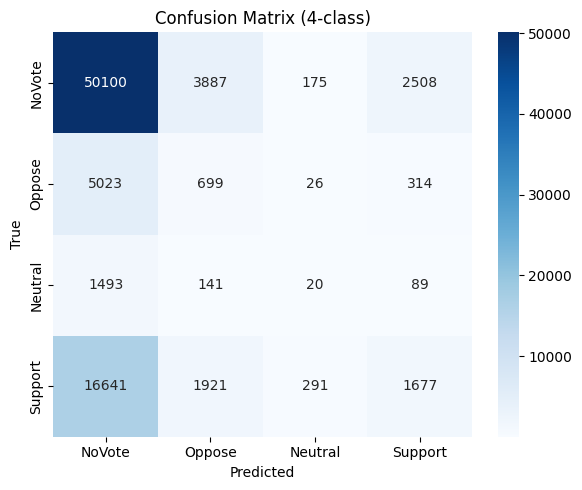

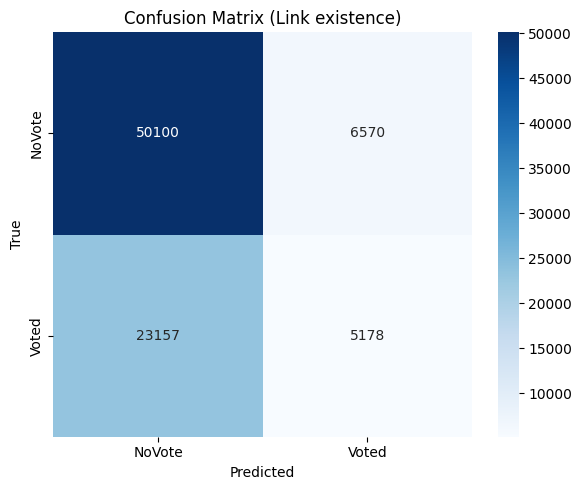

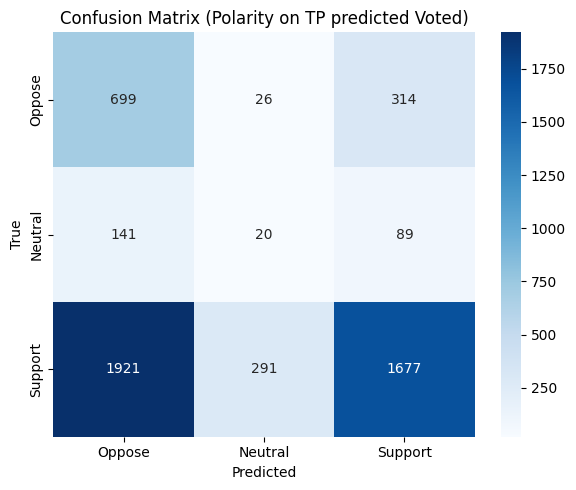

In [16]:
def plot_cm(cm, labels, title, normalize=False):
    if normalize:
        cm_plot = cm.astype(float)
        cm_plot = cm_plot / cm_plot.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        cm_plot = cm.astype(int)   # <-- qui int
        fmt = "d"

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_plot, annot=True, fmt=fmt, cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- 1) 4-class confusion matrix ----
labels_4 = ["NoVote", "Oppose", "Neutral", "Support"]
cm4 = confusion_matrix(y_true_4, y_pred_4, labels=[0,1,2,3])
plot_cm(cm4, labels_4, "Confusion Matrix (4-class)", normalize=False)
# plot_cm(cm4, labels_4, "Confusion Matrix (4-class) - normalized", normalize=True)

# ---- 2) Link existence confusion matrix (NoVote vs Voted) ----
y_true_link = (y_true_4 != 0).astype(int)
y_pred_link = (y_pred_4 != 0).astype(int)
cm_link = confusion_matrix(y_true_link, y_pred_link, labels=[0,1])
plot_cm(cm_link, ["NoVote", "Voted"], "Confusion Matrix (Link existence)", normalize=False)
# plot_cm(cm_link, ["NoVote", "Voted"], "Confusion Matrix (Link existence) - normalized", normalize=True)

# ---- 3) Polarity confusion matrix on TP edges where model predicts Voted ----
mask_tp = (y_true_4 != 0) & (y_pred_4 != 0)
y_true_pol = (y_true_4[mask_tp] - 1)  # {0,1,2}
y_pred_pol = (y_pred_4[mask_tp] - 1)  # {0,1,2}
cm_pol = confusion_matrix(y_true_pol, y_pred_pol, labels=[0,1,2])
plot_cm(cm_pol, ["Oppose", "Neutral", "Support"],
        "Confusion Matrix (Polarity on TP predicted Voted)", normalize=False)
# plot_cm(cm_pol, ["Oppose", "Neutral", "Support"],
#         "Confusion Matrix (Polarity on TP predicted Voted) - normalized", normalize=True)